In [1]:
import sys 
sys.path.append('..')

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import dlib
import os, pickle
import re
import signal
import operator
from sklearn import svm
from sklearn import tree

## Detect face definition (DLIB)

In [35]:
from models.mtcnn.align_dlib import AlignDlib
align = AlignDlib('../models/dlib/shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

def detect_face(img):
    bbs = detector(img, 1)
    tuples = []
    for r in bbs:
        tuples.append((r.left(), r.top(), r.right(), r.bottom()))
    return tuples

## Align Face Definition (DLIB)

In [4]:
EXPECT_SIZE = 160

def align_face(image, face_box, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE):
    assert isinstance(face_box, tuple)
    face_rect = dlib.rectangle(*face_box)
    landmarks = align.findLandmarks(image, face_rect)
    alignedFace = align.align(EXPECT_SIZE, image, face_rect, 
                              landmarks=landmarks,
                              landmarkIndices=landmarkIndices)
    return alignedFace

In [5]:
def draw_rects(image, rects):
    result = image.copy()
    for left, top, right, bottom in rects:
        cv2.rectangle(result, (left, top), (right, bottom), (0, 255, 0), 2)
    return result

## Facenet Initialization Functions

https://github.com/davidsandberg/facenet

In [6]:
def load_model(model_dir, model_meta, model_content):
    s = tf.InteractiveSession()
    model_dir_exp = os.path.expanduser(model_dir)
    saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
    saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
    tf.get_default_graph().as_graph_def()
    return s

In [7]:
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

## Load Facenet

Pre trained model on MS-Celeb-1M

In [8]:
model_dir = '../models/facenet'
meta_file, ckpt_file = get_model_filenames(os.path.expanduser(model_dir))
session = load_model(model_dir, meta_file, ckpt_file)

In [9]:
graph = tf.get_default_graph()
image_batch = graph.get_tensor_by_name("input:0")
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
embeddings = graph.get_tensor_by_name("embeddings:0")

# KNN Functions

In [10]:
def euclideanDistance(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return np.sqrt(distance)

In [11]:
def getNeighbours(X, xt, k):
    distances = []
    for person in range(len(X)):
        for rep in range(len(X[person])):
            dist = euclideanDistance(xt, X[person][rep])
            distances.append((X[person][rep], person, dist))
    distances.sort(key=operator.itemgetter(2))
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i])
    return neighbors

In [12]:
def getResponse(neighbors, classnum):
    classVotes = np.zeros(classnum)
    for n in neighbors:
        response = n[-2]
        classVotes[response] += 1
    y = np.argmax(classVotes)
    return y

# Process Test Image

In [36]:
test_img = '../test_imgs/trump.jpg'
image = mpimg.imread(test_img)

Wall time: 210 ms


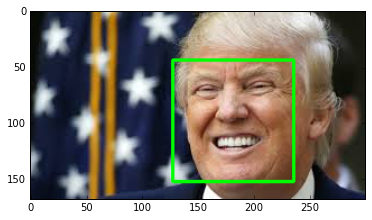

In [37]:
%time rects = detect_face(image)
plt.imshow(draw_rects(image, rects))

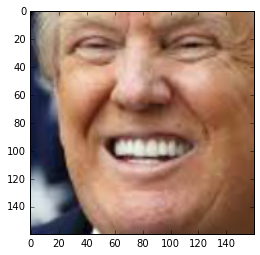

In [38]:
aligned_face = align_face(image, rects[0], AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
plt.imshow(aligned_face)

Feed through Facenet and get representation as 128D Vektor

In [39]:
feed_dict = { 
            image_batch: np.expand_dims(aligned_face, 0), 
            phase_train_placeholder: False }

In [40]:
%time rep = session.run(embeddings, feed_dict=feed_dict)[0]
print(rep[:10],'...', rep[-10:])

Wall time: 657 ms
[-0.16355892 -0.05085414 -0.29569948 -0.06880883  0.08064245 -0.07834463
  0.09507032 -0.00721132 -0.08126315  0.08237108] ... [-0.10396189  0.23075244  0.14603654  0.04505147 -0.11237123 -0.01355185
  0.17377324 -0.07524987  0.08510105  0.1268484 ]


### Apply KNN

Load all Representation of dataset (LFW)

In [41]:
names = np.load('../models/facenet_own_names.npy')
people_reps = np.load('../models/facenet_own_reps.npy')

Find nearest neighbours

In [42]:
k = 3
neighbours = getNeighbours(people_reps, rep, k)

In [43]:
output = getResponse(neighbours, len(names))

In [44]:
classification = names[output]
distance = neighbours[0][2]
print(classification)
print('Distance: ' + str(distance))

Donald Trump
Distance: 0.224117316919


### Apply SVM

In [45]:
# clf = svm.SVC(probability=True)
svm_model = "../models/SVM/own.b"
clf = pickle.load( open( svm_model, "rb" ) )

In [46]:
probabilities = clf.predict_proba(rep.reshape(1,-1))
output = np.argmax(probabilities[0])
print(probabilities[0])

[ 0.30691945  0.15492272  0.25434621  0.23968731  0.04412431]


In [47]:
classification = names[output]
probability = probabilities[0][output]

In [48]:
print(classification)
print('Probability: ' + str(probability))

Bill Gates
Probability: 0.306919453493


### Apply Decision Tree

In [49]:
# clf = tree.DecisionTreeClassifier()
tree_model = "../models/Tree/own.b"
clf = pickle.load( open( tree_model, "rb" ) )

In [50]:
probabilities = clf.predict_proba(rep.reshape(1,-1))
output = np.argmax(probabilities[0])

In [51]:
classification = names[output]
probability = probabilities[0][output]

In [52]:
print(classification)
print('Probability: ' + str(probability))

Donald Trump
Probability: 1.0


# Process Webcam Input

Take Photo

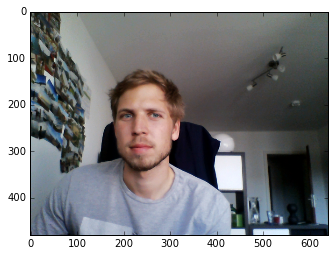

In [66]:
camera = cv2.VideoCapture(0)
return_value,frame = camera.read()
camera.release()
img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(img)

Detect and Align Face

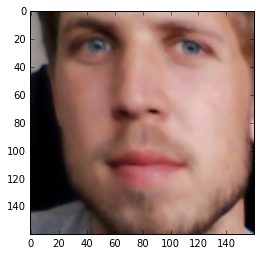

In [67]:
rects = detect_face(img)
aligned_face = align_face(img, rects[0], AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
plt.imshow(aligned_face)

Calculate Embeddings

In [68]:
feed_dict = { 
            image_batch: np.expand_dims(aligned_face, 0), 
            phase_train_placeholder: False }
%time rep = session.run(embeddings, feed_dict=feed_dict)[0]
print(rep[:10],'...', rep[-10:])

Wall time: 612 ms
[-0.19567408 -0.05283632 -0.28176996 -0.071357    0.07110246 -0.08450299
  0.06384238  0.01807982 -0.0280025   0.11039293] ... [-0.07787434  0.1648576   0.15916534  0.02759548 -0.08929725  0.02087901
  0.1809804  -0.07431691  0.09754774  0.11903501]


Classify on DB using KNN

In [69]:
names = np.load('../models/facenet_own_names.npy')
people_reps = np.load('../models/facenet_own_reps.npy')

In [70]:
k = 3
neighbours = getNeighbours(people_reps, rep, k)
output = getResponse(neighbours, len(names))
classification = names[output]
distance = neighbours[0][2]
print(classification)
print('Distance: ' + str(distance))

Fabian
Distance: 0.135584902017
